In [1]:
import os
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline  
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import logging
import imp
imp.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [2]:
class MLTData():
    def __init__(self, batch_size=32, image_size=128, orig_image_size=[480, 640], train_proportion=1):
        self.name = 'mlt'
        self.img_dir = '/media/yi/DATA/data-orig/MLT/image'
        self.box_dir = '/home/yi/code/few_shot/mlt/box'
        self.meta = self.get_meta(self.img_dir, self.box_dir)
 
        self.train_meta = self.assign_meta('train')
        self.test_meta = self.assign_meta('test')
        
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.train_proportion = train_proportion
        num_image = len(self.train_meta['img'])
        self.train_meta['img'] = self.train_meta['img'][0:int(num_image * train_proportion)]
        self.train_meta['box'] = self.train_meta['box'][0:int(num_image * train_proportion)]
        self.train_idx = np.random.permutation(len(self.train_meta['img']))
        self.train_cnt = 0
        self.test_idx = np.random.permutation(len(self.test_meta['img']))
        self.test_cnt = 0
        
        print('number of training image: %d, number of testing image: %d' % 
              (len(self.train_meta['img']), len(self.test_meta['img'])))
        self.compute_statistics('train')
        self.compute_statistics('test')
        
        self.class_map = {3:0, 4:1, 5:2, 6:3, 13:4, 24:5}
        
    def get_meta(self, img_dir, box_dir):
        meta = {}
        meta['img'], meta['box'] = [], []
        for sub_dir in os.listdir(box_dir):
            box_files = os.listdir(os.path.join(box_dir, sub_dir))
            box_files.sort(key=lambda f: int(filter(str.isdigit, f)))
            box_file_names = [os.path.join(box_dir, sub_dir, f) for f in box_files]
            img_files = []
            for f in box_files:
                file_name, file_ext = os.path.splitext(f)
                img_files.append(file_name + '_color.jpg')
            img_file_names = [os.path.join(img_dir, sub_dir, f) for f in img_files]
            meta['img'].extend(img_file_names)
            meta['box'].extend(box_file_names)
        return meta
    
    def assign_meta(self, status='train'):
        num_image = len(self.meta['img'])
        if status == 'train':
            meta = {}
            meta['img'] = self.meta['img'][0:int(num_image * 0.7)]
            meta['box'] = self.meta['box'][0:int(num_image * 0.7)]
        else:
            meta = {}
            meta['img'] = self.meta['img'][int(num_image * 0.7):]
            meta['box'] = self.meta['box'][int(num_image * 0.7):]
        return meta
    
    def compute_statistics(self, status='train'):
        if status == 'train':
            box_meta = self.train_meta['box']
        else:
            box_meta = self.test_meta['box']
        box = []
        for box_file_name in box_meta:
            with open(box_file_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
        box = np.array(box).astype(np.int)

        cls = box[:, 4]
        box = box[:, 0:4]
        cls_labels = set(list(cls))
        count = dict()
        max_count = 0
        total_count = 0
        for cls_label in cls_labels:
            count[cls_label] = (cls == cls_label).sum()
            if count[cls_label] > max_count:
                max_count = count[cls_label]
            total_count = total_count + count[cls_label]
        print(status)
        print(count)
        print(max_count * 1.0 / total_count)

    def get_next_batch(self, status='train'):
        batch_size, im_size, orig_im_size = self.batch_size, self.im_size, self.orig_im_size
        im = np.zeros((batch_size, im_size, im_size, 3))
        orig_im = np.zeros((batch_size, orig_im_size[0], orig_im_size[1], 3))
        boxes = np.zeros((batch_size, 4))
        label = np.zeros(batch_size)
        i = 0
        restart = False
        while i < batch_size:
            if status == 'train':
                image_name = self.train_meta['img'][self.train_idx[self.train_cnt]]
                box_name = self.train_meta['box'][self.train_idx[self.train_cnt]]
            else:
                image_name = self.test_meta['img'][self.test_idx[self.test_cnt]]
                box_name = self.test_meta['box'][self.test_idx[self.test_cnt]]
            image = np.array(Image.open(image_name))
            im_height, im_width = image.shape[0], image.shape[1]
            image = image / 255.0
            
            box = []
            with open(box_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
            box = np.array(box).astype(np.int)
            
            if status == 'train':
                self.train_cnt = self.train_cnt + 1
                if self.train_cnt >= len(self.train_meta['img']):
                    self.train_idx = np.random.permutation(len(self.train_meta['img']))
                    self.train_cnt = 0
                    restart = True
            else:
                self.test_cnt = self.test_cnt + 1
                if self.test_cnt >= len(self.test_meta['img']):
                    self.test_idx = np.random.permutation(len(self.test_meta['img']))
                    self.test_cnt = 0
                    restart = True
            
            for n in range(box.shape[0]):
                cls = box[n, 4]
                bb = box[n, 0:4]
                im[i, :, :, :] = cv2.resize(image, (im_size, im_size), interpolation=cv2.INTER_AREA)
                orig_im[i, :, :, :] = cv2.resize(image, (orig_im_size[1], orig_im_size[0]), interpolation=cv2.INTER_AREA)
                boxes[i, 0] = bb[0] * 1.0 / im_width
                boxes[i, 1] = bb[1] * 1.0 / im_height
                boxes[i, 2] = bb[2] * 1.0 / im_width
                boxes[i, 3] = bb[3] * 1.0 / im_height
                label[i] = self.class_map[cls]
                i = i + 1
                if i >= batch_size:
                    break
        im = im.transpose((0, 3, 1, 2))
        orig_im = orig_im.transpose((0, 3, 1, 2))
        return im, orig_im, boxes, label, restart
    
    def display(self, im, orig_im, box, label): 
        # Plot original large image with bounding box
        orig_im = orig_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im)
        
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        # Plot resized image with bounding box
        im = im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(im)
        
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        plt.show()
        print(label[0])

number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


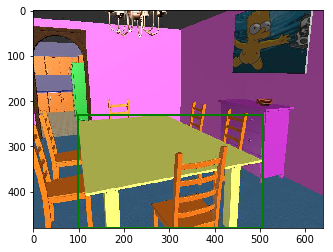

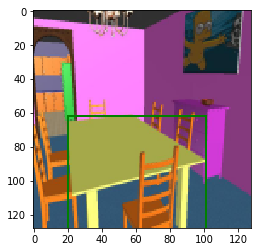

3.0


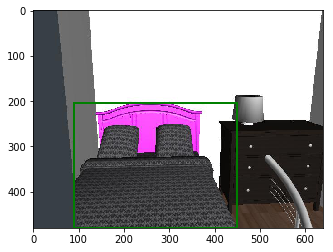

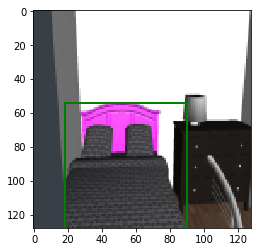

0.0


In [3]:
batch_size = 32
image_size = 128
orig_image_size = [480, 640]
train_proportion = 1
data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
im, orig_im, box, label, _ = data.get_next_batch('train')
data.display(im, orig_im, box, label)
im, orig_im, box, label, _ = data.get_next_batch('test')
data.display(im, orig_im, box, label)

number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


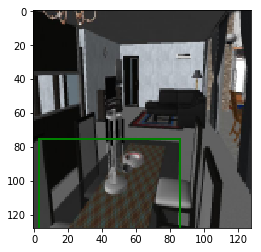

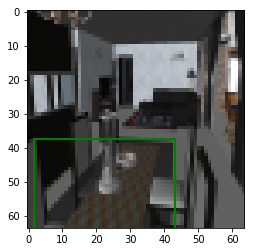

3.0


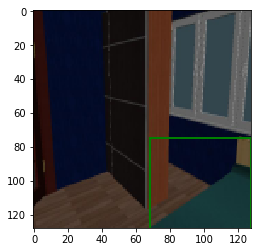

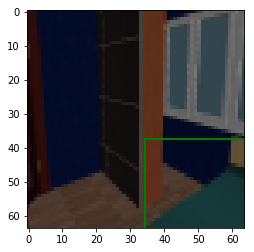

0.0


In [4]:
batch_size = 32
image_size = 64
orig_image_size = [128, 128]
train_proportion = 1
data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
im, orig_im, box, label, _ = data.get_next_batch('train')
data.display(im, orig_im, box, label)
im, orig_im, box, label, _ = data.get_next_batch('test')
data.display(im, orig_im, box, label)

In [5]:
class BaseDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, image_channel, num_class, tensorboard_path, init_model_path, 
                 train_proportion=1):
        logging.info('Baseline demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseNet(self.im_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, label, _ = self.data.get_next_batch('train')
            im = Variable(torch.from_numpy(im).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, label = im.cuda(), label.cuda()
            pred = self.model(im)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, label, _ = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, label = im.cuda(), label.cuda()
            pred = self.model(im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, label = im.cuda(), label.cuda()
            pred = self.model(im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)

In [6]:
class BaseNet(nn.Module):
    def __init__(self, im_size, im_channel, n_class):
        super(BaseNet, self).__init__()
        num_hidden = 32
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        self.fc = nn.Linear(num_hidden*32, n_class)
        self.avgpool = nn.AvgPool2d(im_size / 32, stride=1)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)

    def forward(self, im_input):
        x = self.bn0(im_input)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn6(self.conv6(x6)))
        x7 = self.avgpool(x6)
        x7 = x7.view(x7.size(0), -1)
        pred = self.fc(x7)
        return pred

In [7]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_baseline_100_1'
init_model_path = ''
train_proportion = 1
demo = BaseDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()

12:20:54 INFO:Baseline demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


12:20:58 INFO:epoch 0, train loss: 1.83, average train loss: 1.83
12:20:58 INFO:epoch 0, train accuracy: 0.20, average train accuracy: 0.20
12:20:58 INFO:epoch 1, train loss: 1.86, average train loss: 1.84
12:20:58 INFO:epoch 1, train accuracy: 0.23, average train accuracy: 0.22
12:20:59 INFO:epoch 2, train loss: 1.94, average train loss: 1.88
12:20:59 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.21
12:21:00 INFO:epoch 3, train loss: 1.74, average train loss: 1.84
12:21:00 INFO:epoch 3, train accuracy: 0.20, average train accuracy: 0.21
12:21:01 INFO:epoch 4, train loss: 1.75, average train loss: 1.82
12:21:01 INFO:epoch 4, train accuracy: 0.33, average train accuracy: 0.23
12:21:02 INFO:epoch 5, train loss: 1.77, average train loss: 1.81
12:21:02 INFO:epoch 5, train accuracy: 0.31, average train accuracy: 0.25
12:21:02 INFO:epoch 6, train loss: 1.57, average train loss: 1.78
12:21:02 INFO:epoch 6, train accuracy: 0.38, average train accuracy: 0.27
12:21:03 INFO:epoch 

In [8]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_baseline_100_2'
init_model_path = ''
train_proportion = 1
demo = BaseDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()

12:36:54 INFO:Baseline demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


12:36:55 INFO:epoch 0, train loss: 1.79, average train loss: 1.79
12:36:55 INFO:epoch 0, train accuracy: 0.25, average train accuracy: 0.25
12:36:56 INFO:epoch 1, train loss: 2.04, average train loss: 1.92
12:36:56 INFO:epoch 1, train accuracy: 0.28, average train accuracy: 0.27
12:36:57 INFO:epoch 2, train loss: 1.85, average train loss: 1.89
12:36:57 INFO:epoch 2, train accuracy: 0.25, average train accuracy: 0.26
12:36:58 INFO:epoch 3, train loss: 1.71, average train loss: 1.85
12:36:58 INFO:epoch 3, train accuracy: 0.38, average train accuracy: 0.29
12:36:58 INFO:epoch 4, train loss: 1.93, average train loss: 1.86
12:36:58 INFO:epoch 4, train accuracy: 0.27, average train accuracy: 0.28
12:36:59 INFO:epoch 5, train loss: 1.79, average train loss: 1.85
12:36:59 INFO:epoch 5, train accuracy: 0.19, average train accuracy: 0.27
12:37:00 INFO:epoch 6, train loss: 1.89, average train loss: 1.86
12:37:00 INFO:epoch 6, train accuracy: 0.25, average train accuracy: 0.27
12:37:01 INFO:epoch 

In [9]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_baseline_100_3'
init_model_path = ''
train_proportion = 1
demo = BaseDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()

12:53:03 INFO:Baseline demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


12:53:04 INFO:epoch 0, train loss: 1.79, average train loss: 1.79
12:53:04 INFO:epoch 0, train accuracy: 0.16, average train accuracy: 0.16
12:53:05 INFO:epoch 1, train loss: 1.89, average train loss: 1.84
12:53:05 INFO:epoch 1, train accuracy: 0.20, average train accuracy: 0.18
12:53:06 INFO:epoch 2, train loss: 1.92, average train loss: 1.87
12:53:06 INFO:epoch 2, train accuracy: 0.33, average train accuracy: 0.23
12:53:06 INFO:epoch 3, train loss: 1.85, average train loss: 1.87
12:53:06 INFO:epoch 3, train accuracy: 0.28, average train accuracy: 0.24
12:53:07 INFO:epoch 4, train loss: 1.72, average train loss: 1.84
12:53:07 INFO:epoch 4, train accuracy: 0.36, average train accuracy: 0.27
12:53:08 INFO:epoch 5, train loss: 1.81, average train loss: 1.83
12:53:08 INFO:epoch 5, train accuracy: 0.19, average train accuracy: 0.25
12:53:09 INFO:epoch 6, train loss: 1.78, average train loss: 1.83
12:53:09 INFO:epoch 6, train accuracy: 0.25, average train accuracy: 0.25
12:53:10 INFO:epoch 

In [10]:
class BaseBoxDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, image_channel, num_class, tensorboard_path, init_model_path, 
                 train_proportion=1):
        logging.info('Baseline with box demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseBoxNet(self.im_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, label, _ = self.data.get_next_batch('train')
            im = Variable(torch.from_numpy(im).float())
            box = Variable(torch.from_numpy(box).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, box, label = im.cuda(), box.cuda(), label.cuda()
            pred = self.model(im, box)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, label, _ = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, box, label = im.cuda(), box.cuda(), label.cuda()
            pred = self.model(im, box)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, box, label = im.cuda(), box.cuda(), label.cuda()
            pred = self.model(im, box)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)

In [11]:
class BaseBoxNet(nn.Module):
    def __init__(self, im_size, im_channel, n_class):
        super(BaseBoxNet, self).__init__()
        num_hidden = 32
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        self.avgpool = nn.AvgPool2d(im_size / 32, stride=1)

        self.bn_b0 = nn.BatchNorm1d(4)
        self.fc_b1 = nn.Linear(4, num_hidden)
        self.bn_b1 = nn.BatchNorm1d(num_hidden)
        
        self.fc_all = nn.Linear(num_hidden*33, num_hidden*33)
        self.bn_all = nn.BatchNorm1d(num_hidden*33)
        self.fc = nn.Linear(num_hidden*33, n_class)
        
    def forward(self, im_input, box):
        bbox = torch.zeros_like(box)
        bbox[:, 0] = (box[:, 0] + box[:, 2]) / 2
        bbox[:, 1] = (box[:, 1] + box[:, 3]) / 2
        bbox[:, 2] = box[:, 2] - box[:, 0]
        bbox[:, 3] = box[:, 3] - box[:, 1]
        
        x0 = self.bn0(im_input)
        x1 = F.relu(self.bn1(self.conv1(x0)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn6(self.conv6(x6)))
        x7 = self.avgpool(x6)
        x7 = x7.view(x7.size(0), -1)
        
        b0 = self.bn_b0(bbox)
        b1 = F.relu(self.bn_b1(self.fc_b1(b0)))
        
        x = torch.cat((x7, b1), 1)
        x = F.relu(self.bn_all(self.fc_all(x)))
        pred = self.fc(x)
        return pred

In [12]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_baseline_box_100_1'
init_model_path = ''
train_proportion = 1
demo = BaseBoxDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()

demo.test_all()

01:09:15 INFO:Baseline with box demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


01:09:16 INFO:epoch 0, train loss: 1.86, average train loss: 1.86
01:09:16 INFO:epoch 0, train accuracy: 0.12, average train accuracy: 0.12
01:09:17 INFO:epoch 1, train loss: 1.95, average train loss: 1.91
01:09:17 INFO:epoch 1, train accuracy: 0.20, average train accuracy: 0.16
01:09:18 INFO:epoch 2, train loss: 1.65, average train loss: 1.82
01:09:18 INFO:epoch 2, train accuracy: 0.30, average train accuracy: 0.21
01:09:18 INFO:epoch 3, train loss: 1.82, average train loss: 1.82
01:09:18 INFO:epoch 3, train accuracy: 0.28, average train accuracy: 0.23
01:09:19 INFO:epoch 4, train loss: 1.69, average train loss: 1.79
01:09:19 INFO:epoch 4, train accuracy: 0.36, average train accuracy: 0.25
01:09:20 INFO:epoch 5, train loss: 1.67, average train loss: 1.77
01:09:20 INFO:epoch 5, train accuracy: 0.38, average train accuracy: 0.27
01:09:21 INFO:epoch 6, train loss: 1.65, average train loss: 1.76
01:09:21 INFO:epoch 6, train accuracy: 0.39, average train accuracy: 0.29
01:09:22 INFO:epoch 

In [13]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_baseline_box_100_2'
init_model_path = ''
train_proportion = 1
demo = BaseBoxDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()

demo.test_all()

01:25:26 INFO:Baseline with box demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


01:25:28 INFO:epoch 0, train loss: 1.87, average train loss: 1.87
01:25:28 INFO:epoch 0, train accuracy: 0.08, average train accuracy: 0.08
01:25:28 INFO:epoch 1, train loss: 1.91, average train loss: 1.89
01:25:28 INFO:epoch 1, train accuracy: 0.19, average train accuracy: 0.13
01:25:29 INFO:epoch 2, train loss: 1.80, average train loss: 1.86
01:25:29 INFO:epoch 2, train accuracy: 0.17, average train accuracy: 0.15
01:25:30 INFO:epoch 3, train loss: 1.77, average train loss: 1.84
01:25:30 INFO:epoch 3, train accuracy: 0.25, average train accuracy: 0.17
01:25:31 INFO:epoch 4, train loss: 1.73, average train loss: 1.82
01:25:31 INFO:epoch 4, train accuracy: 0.19, average train accuracy: 0.17
01:25:32 INFO:epoch 5, train loss: 1.67, average train loss: 1.79
01:25:32 INFO:epoch 5, train accuracy: 0.23, average train accuracy: 0.18
01:25:32 INFO:epoch 6, train loss: 1.74, average train loss: 1.79
01:25:32 INFO:epoch 6, train accuracy: 0.30, average train accuracy: 0.20
01:25:33 INFO:epoch 

In [14]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_baseline_box_100_3'
init_model_path = ''
train_proportion = 1
demo = BaseBoxDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()

demo.test_all()

01:41:19 INFO:Baseline with box demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


01:41:20 INFO:epoch 0, train loss: 1.84, average train loss: 1.84
01:41:20 INFO:epoch 0, train accuracy: 0.11, average train accuracy: 0.11
01:41:21 INFO:epoch 1, train loss: 1.78, average train loss: 1.81
01:41:21 INFO:epoch 1, train accuracy: 0.28, average train accuracy: 0.20
01:41:21 INFO:epoch 2, train loss: 2.11, average train loss: 1.91
01:41:21 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.20
01:41:22 INFO:epoch 3, train loss: 1.86, average train loss: 1.90
01:41:22 INFO:epoch 3, train accuracy: 0.17, average train accuracy: 0.19
01:41:23 INFO:epoch 4, train loss: 1.71, average train loss: 1.86
01:41:23 INFO:epoch 4, train accuracy: 0.31, average train accuracy: 0.22
01:41:24 INFO:epoch 5, train loss: 1.70, average train loss: 1.83
01:41:24 INFO:epoch 5, train accuracy: 0.33, average train accuracy: 0.23
01:41:24 INFO:epoch 6, train loss: 1.81, average train loss: 1.83
01:41:24 INFO:epoch 6, train accuracy: 0.25, average train accuracy: 0.24
01:41:25 INFO:epoch 

In [15]:
class GtAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, image_channel, num_class, tensorboard_path, init_model_path, 
                 train_proportion=1):
        logging.info('Baseline with ground truth box crop attention demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        self.model = GtAttnNet(self.batch_size, self.im_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, label, _ = self.data.get_next_batch('train')
            orig_im = Variable(torch.from_numpy(orig_im).float())
            box = Variable(torch.from_numpy(box).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
            pred = self.model(orig_im, box)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, label, _ = self.data.get_next_batch('test')
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
            pred = self.model(orig_im, box)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
            pred = self.model(orig_im, box)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self):
        im, orig_im, box, label, _ = self.data.get_next_batch('test')
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        box = Variable(torch.from_numpy(box).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
        pred = self.model(orig_im, box, display=True)

In [16]:
class GtAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, im_channel, n_class):
        super(BaseAttnNet, self).__init__()
        num_hidden = 32
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        self.avgpool = nn.AvgPool2d(im_size / 32, stride=1)
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)

        grid = np.mgrid[0:im_size, 0:im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size
            
    def stn(self, orig_im, boxes):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        boxes = boxes * 2 - 1
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (boxes[:, 2] - boxes[:, 0]) / self.im_size
        sample_dist_y = (boxes[:, 3] - boxes[:, 1]) / self.im_size
        start_x = boxes[:, 0]
        start_y = boxes[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)        
        crop_im = F.grid_sample(orig_im, grid)
        return crop_im
        
    def forward(self, im_input, boxes, display=False):
        crop_im = self.stn(im_input, boxes)
        if display:
            self.show_box(im_input, boxes, crop_im)    
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn6(self.conv6(x6)))
        x7 = self.avgpool(x6)
        x7 = x7.view(x7.size(0), -1)
        pred = self.fc(x7)
        return pred
    
    def show_box(self, im, box, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, :, :, :].transpose(1, 2, 0)
        
        fig, ax = plt.subplots(1)
        ax.imshow(im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im)
        plt.show()

01:57:11 INFO:Baseline with box crop attention demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


01:57:13 INFO:epoch 0, train loss: 1.80, average train loss: 1.80
01:57:13 INFO:epoch 0, train accuracy: 0.25, average train accuracy: 0.25
01:57:14 INFO:epoch 1, train loss: 1.95, average train loss: 1.87
01:57:14 INFO:epoch 1, train accuracy: 0.22, average train accuracy: 0.23
01:57:15 INFO:epoch 2, train loss: 1.80, average train loss: 1.85
01:57:15 INFO:epoch 2, train accuracy: 0.27, average train accuracy: 0.24
01:57:16 INFO:epoch 3, train loss: 1.88, average train loss: 1.86
01:57:16 INFO:epoch 3, train accuracy: 0.34, average train accuracy: 0.27
01:57:17 INFO:epoch 4, train loss: 1.71, average train loss: 1.83
01:57:17 INFO:epoch 4, train accuracy: 0.27, average train accuracy: 0.27
01:57:18 INFO:epoch 5, train loss: 1.54, average train loss: 1.78
01:57:18 INFO:epoch 5, train accuracy: 0.38, average train accuracy: 0.29
01:57:19 INFO:epoch 6, train loss: 1.57, average train loss: 1.75
01:57:19 INFO:epoch 6, train accuracy: 0.41, average train accuracy: 0.30
01:57:20 INFO:epoch 

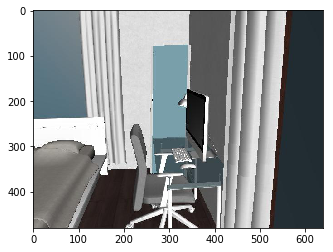

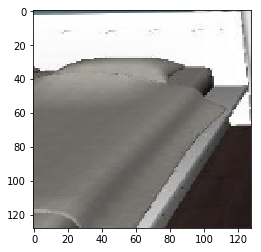

In [17]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_100_1'
init_model_path = ''
train_proportion = 1
demo = GtAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

02:16:59 INFO:Baseline with box crop attention demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


02:17:00 INFO:epoch 0, train loss: 1.82, average train loss: 1.82
02:17:00 INFO:epoch 0, train accuracy: 0.11, average train accuracy: 0.11
02:17:01 INFO:epoch 1, train loss: 1.86, average train loss: 1.84
02:17:01 INFO:epoch 1, train accuracy: 0.30, average train accuracy: 0.20
02:17:02 INFO:epoch 2, train loss: 1.92, average train loss: 1.87
02:17:02 INFO:epoch 2, train accuracy: 0.28, average train accuracy: 0.23
02:17:03 INFO:epoch 3, train loss: 1.58, average train loss: 1.80
02:17:03 INFO:epoch 3, train accuracy: 0.28, average train accuracy: 0.24
02:17:04 INFO:epoch 4, train loss: 1.59, average train loss: 1.75
02:17:04 INFO:epoch 4, train accuracy: 0.33, average train accuracy: 0.26
02:17:05 INFO:epoch 5, train loss: 1.64, average train loss: 1.73
02:17:05 INFO:epoch 5, train accuracy: 0.27, average train accuracy: 0.26
02:17:06 INFO:epoch 6, train loss: 1.56, average train loss: 1.71
02:17:06 INFO:epoch 6, train accuracy: 0.28, average train accuracy: 0.26
02:17:07 INFO:epoch 

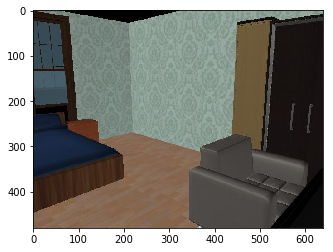

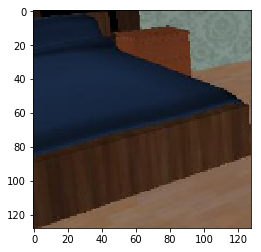

In [18]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_100_2'
init_model_path = ''
train_proportion = 1
demo = GtAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

02:36:39 INFO:Baseline with box crop attention demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


02:36:40 INFO:epoch 0, train loss: 1.81, average train loss: 1.81
02:36:40 INFO:epoch 0, train accuracy: 0.16, average train accuracy: 0.16
02:36:41 INFO:epoch 1, train loss: 1.79, average train loss: 1.80
02:36:41 INFO:epoch 1, train accuracy: 0.28, average train accuracy: 0.22
02:36:42 INFO:epoch 2, train loss: 1.83, average train loss: 1.81
02:36:42 INFO:epoch 2, train accuracy: 0.33, average train accuracy: 0.26
02:36:43 INFO:epoch 3, train loss: 1.79, average train loss: 1.81
02:36:43 INFO:epoch 3, train accuracy: 0.31, average train accuracy: 0.27
02:36:44 INFO:epoch 4, train loss: 2.11, average train loss: 1.87
02:36:44 INFO:epoch 4, train accuracy: 0.19, average train accuracy: 0.25
02:36:45 INFO:epoch 5, train loss: 1.63, average train loss: 1.83
02:36:45 INFO:epoch 5, train accuracy: 0.30, average train accuracy: 0.26
02:36:46 INFO:epoch 6, train loss: 1.59, average train loss: 1.79
02:36:46 INFO:epoch 6, train accuracy: 0.34, average train accuracy: 0.27
02:36:47 INFO:epoch 

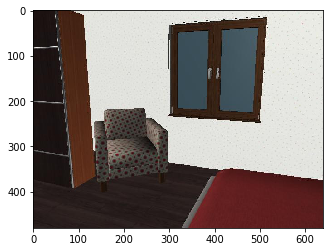

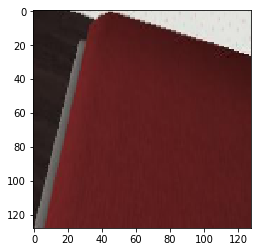

In [19]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [480, 640]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_100_3'
init_model_path = ''
train_proportion = 1
demo = GtAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

02:56:56 INFO:Baseline with box crop attention demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


02:56:57 INFO:epoch 0, train loss: 1.79, average train loss: 1.79
02:56:57 INFO:epoch 0, train accuracy: 0.12, average train accuracy: 0.12
02:56:58 INFO:epoch 1, train loss: 1.69, average train loss: 1.74
02:56:58 INFO:epoch 1, train accuracy: 0.28, average train accuracy: 0.20
02:56:58 INFO:epoch 2, train loss: 1.83, average train loss: 1.77
02:56:58 INFO:epoch 2, train accuracy: 0.27, average train accuracy: 0.22
02:56:59 INFO:epoch 3, train loss: 1.54, average train loss: 1.71
02:56:59 INFO:epoch 3, train accuracy: 0.42, average train accuracy: 0.27
02:56:59 INFO:epoch 4, train loss: 1.74, average train loss: 1.72
02:56:59 INFO:epoch 4, train accuracy: 0.27, average train accuracy: 0.27
02:57:00 INFO:epoch 5, train loss: 1.78, average train loss: 1.73
02:57:00 INFO:epoch 5, train accuracy: 0.30, average train accuracy: 0.28
02:57:00 INFO:epoch 6, train loss: 1.75, average train loss: 1.73
02:57:00 INFO:epoch 6, train accuracy: 0.23, average train accuracy: 0.27
02:57:01 INFO:epoch 

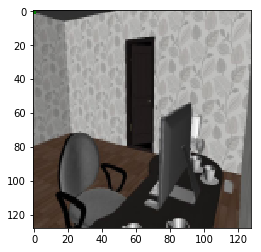

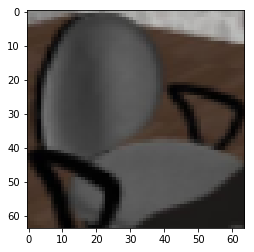

In [20]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [128, 128]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_small64_100_1'
init_model_path = ''
train_proportion = 1
demo = GtAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

03:06:28 INFO:Baseline with box crop attention demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


03:06:29 INFO:epoch 0, train loss: 1.82, average train loss: 1.82
03:06:29 INFO:epoch 0, train accuracy: 0.06, average train accuracy: 0.06
03:06:29 INFO:epoch 1, train loss: 1.96, average train loss: 1.89
03:06:29 INFO:epoch 1, train accuracy: 0.09, average train accuracy: 0.08
03:06:30 INFO:epoch 2, train loss: 1.80, average train loss: 1.86
03:06:30 INFO:epoch 2, train accuracy: 0.23, average train accuracy: 0.13
03:06:30 INFO:epoch 3, train loss: 1.63, average train loss: 1.80
03:06:30 INFO:epoch 3, train accuracy: 0.39, average train accuracy: 0.20
03:06:31 INFO:epoch 4, train loss: 1.71, average train loss: 1.79
03:06:31 INFO:epoch 4, train accuracy: 0.44, average train accuracy: 0.24
03:06:31 INFO:epoch 5, train loss: 1.75, average train loss: 1.78
03:06:31 INFO:epoch 5, train accuracy: 0.20, average train accuracy: 0.24
03:06:32 INFO:epoch 6, train loss: 1.74, average train loss: 1.78
03:06:32 INFO:epoch 6, train accuracy: 0.28, average train accuracy: 0.24
03:06:32 INFO:epoch 

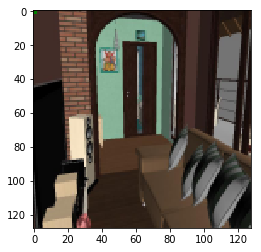

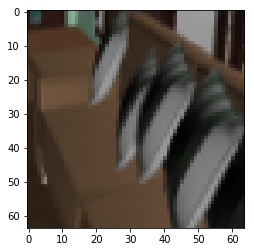

In [21]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [128, 128]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_small64_100_2'
init_model_path = ''
train_proportion = 1
demo = GtAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

03:15:58 INFO:Baseline with box crop attention demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


03:15:59 INFO:epoch 0, train loss: 1.76, average train loss: 1.76
03:15:59 INFO:epoch 0, train accuracy: 0.25, average train accuracy: 0.25
03:15:59 INFO:epoch 1, train loss: 1.94, average train loss: 1.85
03:15:59 INFO:epoch 1, train accuracy: 0.27, average train accuracy: 0.26
03:16:00 INFO:epoch 2, train loss: 1.72, average train loss: 1.81
03:16:00 INFO:epoch 2, train accuracy: 0.22, average train accuracy: 0.24
03:16:00 INFO:epoch 3, train loss: 1.53, average train loss: 1.74
03:16:00 INFO:epoch 3, train accuracy: 0.25, average train accuracy: 0.25
03:16:01 INFO:epoch 4, train loss: 1.47, average train loss: 1.68
03:16:01 INFO:epoch 4, train accuracy: 0.39, average train accuracy: 0.28
03:16:01 INFO:epoch 5, train loss: 1.60, average train loss: 1.67
03:16:01 INFO:epoch 5, train accuracy: 0.30, average train accuracy: 0.28
03:16:02 INFO:epoch 6, train loss: 1.56, average train loss: 1.65
03:16:02 INFO:epoch 6, train accuracy: 0.33, average train accuracy: 0.29
03:16:02 INFO:epoch 

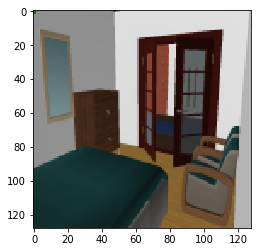

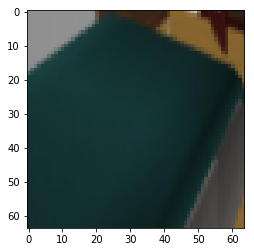

In [22]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [128, 128]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_small64_100_3'
init_model_path = ''
train_proportion = 1
demo = GtAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

In [23]:
class GtAttnCombDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, image_channel, num_class, tensorboard_path, init_model_path, 
                 train_proportion=1):
        logging.info('Baseline with ground truth box crop attention combination with image demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        assert(self.orig_im_size[0] == self.orig_im_size[1])
        self.model = GtAttnCombNet(self.batch_size, self.im_size, self.orig_im_size[0], self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, label, _ = self.data.get_next_batch('train')
            orig_im = Variable(torch.from_numpy(orig_im).float())
            box = Variable(torch.from_numpy(box).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
            pred = self.model(orig_im, box)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, label, _ = self.data.get_next_batch('test')
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
            pred = self.model(orig_im, box)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
            pred = self.model(orig_im, box)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self):
        im, orig_im, box, label, _ = self.data.get_next_batch('test')
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        box = Variable(torch.from_numpy(box).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            orig_im, box, label = orig_im.cuda(), box.cuda(), label.cuda()
        pred = self.model(orig_im, box, display=True)

In [24]:
class GtAttnCombNet(nn.Module):
    def __init__(self, batch_size, im_size, orig_im_size, im_channel, n_class):
        super(GtAttnCombNet, self).__init__()
        num_hidden = 32
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        self.avgpool1 = nn.AvgPool2d(orig_im_size / 32, stride=1)
        self.avgpool2 = nn.AvgPool2d(im_size / 32, stride=1)

        grid = np.mgrid[0:im_size, 0:im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size
            
    def stn(self, im, boxes):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        boxes = boxes * 2 - 1   
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (boxes[:, 2] - boxes[:, 0]) / self.im_size
        sample_dist_y = (boxes[:, 3] - boxes[:, 1]) / self.im_size
        start_x = boxes[:, 0]
        start_y = boxes[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)        
        crop_im = F.grid_sample(im, grid)
        return crop_im
        
    def forward(self, im_input, boxes, display=False):
        # predict using full resized image first
        x = self.bn0(im_input)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn6(self.conv6(x6)))
        x7 = self.avgpool1(x6)
        x7 = x7.view(x7.size(0), -1)
        pred1 = self.fc(x7)

        # predict using attention area from spatial transformer network on high resolution image second
        crop_im = self.stn(im_input, boxes)
        if display:
            self.show_box(im_input, boxes, crop_im)    
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn6(self.conv6(x6)))
        x7 = self.avgpool2(x6)
        x7 = x7.view(x7.size(0), -1)
        pred2 = self.fc(x7)
        
        # a simple model average
        pred = (pred1 + pred2) / 2
        return pred
    
    def show_box(self, im, box, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, :, :, :].transpose(1, 2, 0)
        
        fig, ax = plt.subplots(1)
        ax.imshow(im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im)
        plt.show()

03:25:41 INFO:Baseline with box crop attention combination with image demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


03:25:42 INFO:epoch 0, train loss: 1.80, average train loss: 1.80
03:25:42 INFO:epoch 0, train accuracy: 0.06, average train accuracy: 0.06
03:25:43 INFO:epoch 1, train loss: 1.72, average train loss: 1.76
03:25:43 INFO:epoch 1, train accuracy: 0.38, average train accuracy: 0.22
03:25:43 INFO:epoch 2, train loss: 1.82, average train loss: 1.78
03:25:43 INFO:epoch 2, train accuracy: 0.25, average train accuracy: 0.23
03:25:44 INFO:epoch 3, train loss: 1.88, average train loss: 1.81
03:25:44 INFO:epoch 3, train accuracy: 0.27, average train accuracy: 0.24
03:25:44 INFO:epoch 4, train loss: 1.73, average train loss: 1.79
03:25:44 INFO:epoch 4, train accuracy: 0.30, average train accuracy: 0.25
03:25:45 INFO:epoch 5, train loss: 1.65, average train loss: 1.77
03:25:45 INFO:epoch 5, train accuracy: 0.25, average train accuracy: 0.25
03:25:46 INFO:epoch 6, train loss: 1.53, average train loss: 1.73
03:25:46 INFO:epoch 6, train accuracy: 0.45, average train accuracy: 0.28
03:25:46 INFO:epoch 

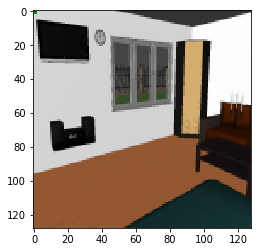

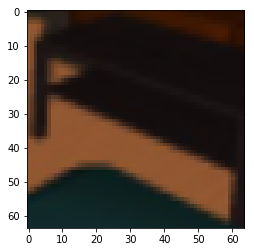

In [25]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [128, 128]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_comb_small64_100_1'
init_model_path = ''
train_proportion = 1
demo = GtAttnCombDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                        orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

03:38:53 INFO:Baseline with box crop attention combination with image demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


03:38:54 INFO:epoch 0, train loss: 1.77, average train loss: 1.77
03:38:54 INFO:epoch 0, train accuracy: 0.22, average train accuracy: 0.22
03:38:55 INFO:epoch 1, train loss: 1.90, average train loss: 1.83
03:38:55 INFO:epoch 1, train accuracy: 0.17, average train accuracy: 0.20
03:38:56 INFO:epoch 2, train loss: 1.76, average train loss: 1.81
03:38:56 INFO:epoch 2, train accuracy: 0.19, average train accuracy: 0.19
03:38:56 INFO:epoch 3, train loss: 1.82, average train loss: 1.81
03:38:56 INFO:epoch 3, train accuracy: 0.30, average train accuracy: 0.22
03:38:57 INFO:epoch 4, train loss: 1.81, average train loss: 1.81
03:38:57 INFO:epoch 4, train accuracy: 0.17, average train accuracy: 0.21
03:38:58 INFO:epoch 5, train loss: 1.90, average train loss: 1.83
03:38:58 INFO:epoch 5, train accuracy: 0.22, average train accuracy: 0.21
03:38:58 INFO:epoch 6, train loss: 1.58, average train loss: 1.79
03:38:58 INFO:epoch 6, train accuracy: 0.30, average train accuracy: 0.22
03:38:59 INFO:epoch 

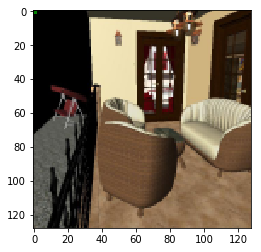

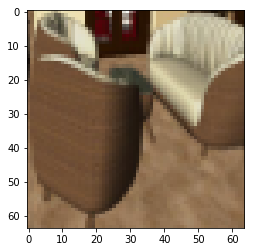

In [26]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [128, 128]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_comb_small64_100_2'
init_model_path = ''
train_proportion = 1
demo = GtAttnCombDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                        orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

03:52:11 INFO:Baseline with box crop attention combination with image demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


03:52:12 INFO:epoch 0, train loss: 1.79, average train loss: 1.79
03:52:12 INFO:epoch 0, train accuracy: 0.16, average train accuracy: 0.16
03:52:12 INFO:epoch 1, train loss: 1.96, average train loss: 1.87
03:52:12 INFO:epoch 1, train accuracy: 0.17, average train accuracy: 0.16
03:52:13 INFO:epoch 2, train loss: 1.70, average train loss: 1.82
03:52:13 INFO:epoch 2, train accuracy: 0.34, average train accuracy: 0.22
03:52:14 INFO:epoch 3, train loss: 1.85, average train loss: 1.82
03:52:14 INFO:epoch 3, train accuracy: 0.27, average train accuracy: 0.23
03:52:15 INFO:epoch 4, train loss: 1.70, average train loss: 1.80
03:52:15 INFO:epoch 4, train accuracy: 0.36, average train accuracy: 0.26
03:52:15 INFO:epoch 5, train loss: 1.80, average train loss: 1.80
03:52:15 INFO:epoch 5, train accuracy: 0.23, average train accuracy: 0.26
03:52:16 INFO:epoch 6, train loss: 1.75, average train loss: 1.79
03:52:16 INFO:epoch 6, train accuracy: 0.22, average train accuracy: 0.25
03:52:16 INFO:epoch 

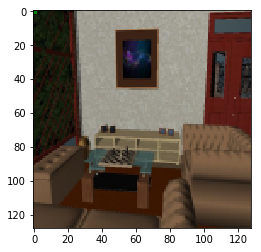

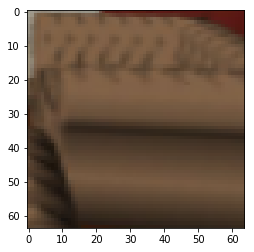

In [27]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 64
orig_im_size = [128, 128]
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_gt_attn_comb_small64_100_3'
init_model_path = ''
train_proportion = 1
demo = GtAttnCombDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                        orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

In [31]:
class BaseAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, attention_image_size, image_channel, num_class, tensorboard_path, 
                 init_model_path, train_proportion=1):
        logging.info('Baseline with estimated attention demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_im_size = attention_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseAttnNet(self.batch_size, self.im_size, self.attn_im_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, label, _ = self.data.get_next_batch('train')
            im = Variable(torch.from_numpy(im).float())
            box = Variable(torch.from_numpy(box).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, box, label = im.cuda(), box.cuda(), label.cuda()
            pred = self.model(im, im)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, label, _ = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, box, label = im.cuda(), box.cuda(), label.cuda()
            pred = self.model(im, im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, box, label = im.cuda(), box.cuda(), label.cuda()
            pred = self.model(im, im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self):
        im, orig_im, box, label, _ = self.data.get_next_batch('test')
        im = Variable(torch.from_numpy(im).float(), volatile=True)
        box = Variable(torch.from_numpy(box).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im, box, label = im.cuda(), box.cuda(), label.cuda()
        pred = self.model(im, im, display=True)

In [99]:
class BaseAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_im_size, im_channel, n_class):
        super(BaseAttnNet, self).__init__()
        num_hidden = 32
        
        self.bn_a0 = nn.BatchNorm2d(im_channel)
        self.conv_a1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn_a1 = nn.BatchNorm2d(num_hidden)
        self.conv_a2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn_a2 = nn.BatchNorm2d(num_hidden*2)
        self.conv_a3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn_a3 = nn.BatchNorm2d(num_hidden*4)
        self.conv_a4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn_a4 = nn.BatchNorm2d(num_hidden*8)
        self.conv_a5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn_a5 = nn.BatchNorm2d(num_hidden*16)
        self.conv_a6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn_a6 = nn.BatchNorm2d(num_hidden*32)
        self.avgpool_a = nn.AvgPool2d(im_size / 32, stride=1)
        self.fc_box = nn.Linear(num_hidden*32, 4)
        self.fc_box.weight.data.zero_()
        self.fc_box.bias.data.zero_()
        # self.fc_box.bias.data.copy_(torch.FloatTensor([0, 0, 1, 1]))
        
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        self.avgpool = nn.AvgPool2d(attn_im_size / 32, stride=1)
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        grid = np.mgrid[0:attn_im_size, 0:attn_im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_im_size = attn_im_size
    
    def crop_image2(self, im, box):
        theta = Variable(torch.zeros(self.batch_size, 2, 3))
        if torch.cuda.is_available():
            theta = theta.cuda()

        theta[:, 0, 0] = box[:, 2]
        theta[:, 0, 2] = box[:, 0]
        theta[:, 1, 1] = box[:, 3]
        theta[:, 1, 2] = box[:, 1]

        # theta = torch.cat([boxes[:, 2], zero, boxes[:,0], zero, boxes[:,3], boxes[:, 1]], 1)        
        # theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, torch.Size((self.batch_size, 1, self.attn_im_size, self.attn_im_size)))
        boxes = torch.zeros_like(box)
        boxes[:, 0], _ = torch.min(grid[:, :, :, 0].contiguous().view(self.batch_size, -1), 1)
        boxes[:, 1], _ = torch.min(grid[:, :, :, 1].contiguous().view(self.batch_size, -1), 1)
        boxes[:, 2], _ = torch.max(grid[:, :, :, 0].contiguous().view(self.batch_size, -1), 1)
        boxes[:, 3], _ = torch.max(grid[:, :, :, 1].contiguous().view(self.batch_size, -1), 1)
        boxes = (boxes + 1) / 2
        crop_im = F.grid_sample(im, grid)
        return crop_im, boxes
        
    def stn(self, im):
        # predict bounding box
        x = self.bn_a0(im)
        x1 = F.relu(self.bn_a1(self.conv_a1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn_a2(self.conv_a2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn_a3(self.conv_a3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn_a4(self.conv_a4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn_a5(self.conv_a5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn_a6(self.conv_a6(x6)))
        x7 = self.avgpool_a(x6)
        x7 = x7.view(x7.size(0), -1)
        box = self.fc_box(x7)
        return box
    
    def crop_image(self, im, box):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        box = F.sigmoid(box)
        boxes = torch.zeros_like(box)
        boxes[:, 0] = box[:, 0] - box[:, 2] / 2.0
        boxes[:, 1] = box[:, 1] - box[:, 3] / 2.0
        boxes[:, 2] = box[:, 0] + box[:, 2] / 2.0
        boxes[:, 3] = box[:, 1] + box[:, 3] / 2.0
        boxes = F.relu(boxes)
        boxes = 1 - F.relu(1 - boxes)
        bb = boxes * 2 - 1
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (bb[:, 2] - bb[:, 0]) / self.attn_im_size
        sample_dist_y = (bb[:, 3] - bb[:, 1]) / self.attn_im_size
        start_x = bb[:, 0]
        start_y = bb[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)        
        crop_im = F.grid_sample(im, grid)
        return crop_im, boxes
    
    def forward(self, im, orig_im, display=False):
        box = self.stn(im)
        # predict using attention area from spatial transformer network on high resolution image second
        crop_im, boxes = self.crop_image(orig_im, box)
        if display:
            self.show_box(orig_im, boxes, crop_im)
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x6 = self.maxpool(x5)
        x6 = F.relu(self.bn6(self.conv6(x6)))
        x7 = self.avgpool(x6)
        x7 = x7.view(x7.size(0), -1)
        pred = self.fc(x7)
        return pred
    
    def show_box(self, im, box, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, :, :, :].transpose(1, 2, 0)
        
        fig, ax = plt.subplots(1)
        ax.imshow(im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im)
        plt.show()
        
        print(box)

11:05:23 INFO:Baseline demo


number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


11:05:24 INFO:epoch 0, train loss: 1.83, average train loss: 1.83
11:05:24 INFO:epoch 0, train accuracy: 0.06, average train accuracy: 0.06
11:05:24 INFO:epoch 1, train loss: 1.95, average train loss: 1.89
11:05:24 INFO:epoch 1, train accuracy: 0.28, average train accuracy: 0.17
11:05:25 INFO:epoch 2, train loss: 1.82, average train loss: 1.87
11:05:25 INFO:epoch 2, train accuracy: 0.27, average train accuracy: 0.20
11:05:26 INFO:epoch 3, train loss: 1.78, average train loss: 1.85
11:05:26 INFO:epoch 3, train accuracy: 0.30, average train accuracy: 0.23
11:05:26 INFO:epoch 4, train loss: 1.75, average train loss: 1.83
11:05:26 INFO:epoch 4, train accuracy: 0.22, average train accuracy: 0.23
11:05:27 INFO:epoch 5, train loss: 1.81, average train loss: 1.82
11:05:27 INFO:epoch 5, train accuracy: 0.17, average train accuracy: 0.22
11:05:27 INFO:epoch 6, train loss: 1.70, average train loss: 1.80
11:05:27 INFO:epoch 6, train accuracy: 0.36, average train accuracy: 0.24
11:05:28 INFO:epoch 

number of training image: 10742, number of testing image: 4605
train
{3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}
0.25939754780765933
test
{3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}
0.25585542741647843


11:16:08 INFO:epoch 0, train loss: 1.80, average train loss: 1.80
11:16:08 INFO:epoch 0, train accuracy: 0.31, average train accuracy: 0.31
11:16:09 INFO:epoch 1, train loss: 1.75, average train loss: 1.77
11:16:09 INFO:epoch 1, train accuracy: 0.36, average train accuracy: 0.34
11:16:10 INFO:epoch 2, train loss: 1.55, average train loss: 1.70
11:16:10 INFO:epoch 2, train accuracy: 0.42, average train accuracy: 0.36
11:16:10 INFO:epoch 3, train loss: 1.59, average train loss: 1.67
11:16:10 INFO:epoch 3, train accuracy: 0.36, average train accuracy: 0.36
11:16:11 INFO:epoch 4, train loss: 1.74, average train loss: 1.68
11:16:11 INFO:epoch 4, train accuracy: 0.38, average train accuracy: 0.37
11:16:12 INFO:epoch 5, train loss: 1.82, average train loss: 1.70
11:16:12 INFO:epoch 5, train accuracy: 0.23, average train accuracy: 0.34
11:16:12 INFO:epoch 6, train loss: 1.81, average train loss: 1.72
11:16:12 INFO:epoch 6, train accuracy: 0.28, average train accuracy: 0.33
11:16:13 INFO:epoch 

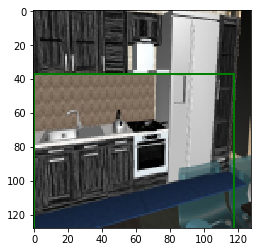

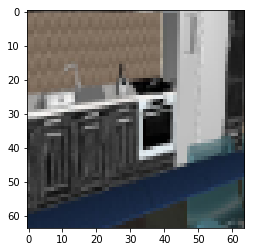

[[0.         0.2887199  0.91935575 1.        ]
 [0.0892415  0.3985188  1.         1.        ]
 [0.0892415  0.3985188  1.         1.        ]
 [0.         0.372207   0.95585245 1.        ]
 [0.         0.372207   0.9558525  1.        ]
 [0.00976419 0.34200072 0.9984747  1.        ]
 [0.00976419 0.34200072 0.9984747  1.        ]
 [0.         0.3117854  0.8768608  1.        ]
 [0.08771908 0.39379406 1.         1.        ]
 [0.08709693 0.3882808  1.         1.        ]
 [0.08709693 0.3882808  1.         1.        ]
 [0.08709693 0.3882808  1.         1.        ]
 [0.00868386 0.31541145 0.98207027 1.        ]
 [0.         0.3112085  0.96531904 1.        ]
 [0.         0.30255854 0.9447509  1.        ]
 [0.         0.31985164 0.88053596 1.        ]
 [0.         0.31985164 0.88053596 1.        ]
 [0.         0.31985164 0.88053596 1.        ]
 [0.00635719 0.3134328  0.98112977 1.        ]
 [0.0905776  0.39720702 1.         1.        ]
 [0.0905776  0.39720702 1.         1.        ]
 [0.0905776  

In [103]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 128
orig_im_size = [128, 128]
attn_im_size = 64
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_base_attn_small64_100_1'
init_model_path = ''
train_proportion = 1
demo0 = BaseDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                 orig_im_size, im_channel, n_class, tensorboard_path, init_model_path, train_proportion)
if command == 'train':
    demo0.train()
elif command == 'test':
    demo0.test()
demo = BaseAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, attn_im_size, im_channel, n_class, tensorboard_path, init_model_path, 
                    train_proportion)
demo.model.bn0.weight.data = demo0.model.bn0.weight.data
demo.model.bn0.bias.data = demo0.model.bn0.bias.data
demo.model.conv1.weight.data = demo0.model.conv1.weight.data
demo.model.conv1.bias.data = demo0.model.conv1.bias.data
demo.model.bn1.weight.data = demo0.model.bn1.weight.data
demo.model.bn1.bias.data = demo0.model.bn1.bias.data
demo.model.conv2.weight.data = demo0.model.conv2.weight.data
demo.model.conv2.bias.data = demo0.model.conv2.bias.data
demo.model.bn2.weight.data = demo0.model.bn2.weight.data
demo.model.bn2.bias.data = demo0.model.bn2.bias.data
demo.model.conv3.weight.data = demo0.model.conv3.weight.data
demo.model.conv3.bias.data = demo0.model.conv3.bias.data
demo.model.bn3.weight.data = demo0.model.bn3.weight.data
demo.model.bn3.bias.data = demo0.model.bn3.bias.data
demo.model.conv4.weight.data = demo0.model.conv4.weight.data
demo.model.conv4.bias.data = demo0.model.conv4.bias.data
demo.model.bn4.weight.data = demo0.model.bn4.weight.data
demo.model.bn4.bias.data = demo0.model.bn4.bias.data
demo.model.conv5.weight.data = demo0.model.conv5.weight.data
demo.model.conv5.bias.data = demo0.model.conv5.bias.data
demo.model.bn5.weight.data = demo0.model.bn5.weight.data
demo.model.bn5.bias.data = demo0.model.bn5.bias.data
demo.model.conv6.weight.data = demo0.model.conv6.weight.data
demo.model.conv6.bias.data = demo0.model.conv6.bias.data
demo.model.bn6.weight.data = demo0.model.bn6.weight.data
demo.model.bn6.bias.data = demo0.model.bn6.bias.data
demo.model.fc.weight.data = demo0.model.fc.weight.data
demo.model.fc.bias.data = demo0.model.fc.bias.data
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

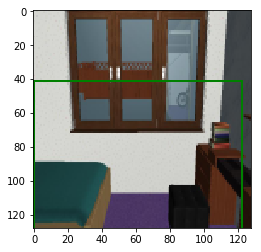

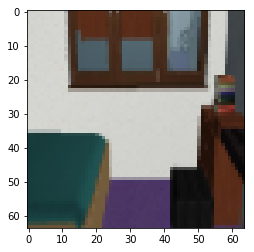

[[0.         0.31997776 0.9573878  1.        ]
 [0.         0.31997776 0.9573878  1.        ]
 [0.00493991 0.3343414  0.9886762  1.        ]
 [0.00493991 0.3343414  0.9886762  1.        ]
 [0.00493991 0.3343414  0.9886762  1.        ]
 [0.08666891 0.39152634 1.         1.        ]
 [0.06472671 0.38621235 1.         1.        ]
 [0.         0.38708508 0.83162075 1.        ]
 [0.         0.28025067 0.8972888  1.        ]
 [0.         0.3031993  0.9503248  1.        ]
 [0.04183108 0.36716694 1.         1.        ]
 [0.04183108 0.36716694 1.         1.        ]
 [0.         0.2936133  0.9043982  1.        ]
 [0.         0.2936133  0.90439826 1.        ]
 [0.         0.2936133  0.9043982  1.        ]
 [0.08389521 0.38977295 1.         1.        ]
 [0.02608782 0.37328148 1.         1.        ]
 [0.0660913  0.37609422 1.         1.        ]
 [0.08399367 0.3863709  1.         1.        ]
 [0.08399367 0.3863709  1.         1.        ]
 [0.08399367 0.3863709  1.         1.        ]
 [0.08741105 

In [104]:
demo.visualize()